# MultiUniMulitplication

A unit is a Strassen-Multiplication StepFunction.
Matrix multiplication to be performed is `m.dot(m.transpose)` with `m.dim(4000,4000)`.
M will be divided into `4*4=16` matrix partitions of dimension `1000*1000`. Partitions will be named m_row_col from m_0_0, m_0_1 ... to m_3_3.


m_0_0  |  m_0_1  |  m_0_2  |  m_0_3

m_1_0  |  m_1_1  |  m_1_2  |  m_1_3

m_2_0  |  m_2_1  |  m_2_2  |  m_2_3

m_3_0  |  m_3_1  |  m_3_2  |  m_3_3

## Content

1. Matrix Creation (matrix_dimension, block_sizes)
2. Matrix deployment (bucket, matrix_names)
3. Matrix multiplication (invoke matrix-multiplication-lambda)
4. check results in S3
5. create time profile for 3 stages (interm., collection, accumulation)
6. Compare Timings

matrix dimensions: 4000x4000, 8000x8000, 2000x16000   
block sizes: 1000x1000, 2000x2000, 3000x3000

In [46]:
from collections import namedtuple
MatrixDimensions = namedtuple("MatrixDimensions", ['height', 'width'])

In [140]:
# global test variables
matrix_dimensions = MatrixDimensions(height=2000,width=2000)
block_size = 1000
bucket = "jmue-matrix-tests"
prefix = "square_matrix"
matrix_name = "{}_{}kx{}k".format(prefix, matrix_dimensions.height/1000, matrix_dimensions.width/1000) 

## 1. Matrix Creation

### Generate Matrix Blocks

In [141]:
import numpy as np
import os

In [142]:
def write_block_to_file(block, directory, row, column):
    if not os.path.exists(directory):
        os.mkdir(directory)
    path = os.path.join(directory, "m_" + str(row) + "_" + str(column))
    np.save(path, block)

### a. create specific matrix and split it

In [143]:
def split_matrix_into(matrix, x, y, block_size):
    '''split matrix into x*y partitions of given size'''
    p = block_size
    for i in range(0,x):
        for j in range(0,y):
            block = matrix[i*p:(i+1)*p, j*p:(j+1)*p]
            directory = "/tmp/" + matrix_name
            write_block_to_file(block, directory, i, j)

In [144]:
def create_square_staircase_matrix(matrix_dimensions):
    matrix = np.zeros(matrix_dimensions, dtype=np.int)
    for i in range(matrix_dimensions.height):
        for j in range(matrix_dimensions.width):
            matrix[i][j] = i+j
    return np.array(matrix)

In [145]:
sq_m = create_square_staircase_matrix(matrix_dimensions)

In [261]:
sq_m = np.transpose(create_square_staircase_matrix(width=4000))
split_matrix_into(sq_m, 4, 4, 1000)

### OR b. alternatively create random blocks

In [67]:
def get_block_with_random(height, width):
    return np.random.random_sample((height,width))


In [147]:
def create_blocks_with_random(x, y, height, width, matrix_name=matrix_name):
    for i in range(0,x):
        for j in range(0,y):
            block = get_block_with_random(height, width)
            directory = "/tmp/" + matrix_name
            write_block_to_file(block, directory, i, j)

In [150]:
create_blocks_with_random(matrix_dimensions.height/1000, matrix_dimensions.width/1000, block_size, block_size)

In [151]:
create_blocks_with_random(matrix_dimensions.height/1000, matrix_dimensions.width/1000, block_size, block_size, matrix_name=matrix_name + "-2")

## 2. Matrix Deployment

In [78]:
import boto3

In [152]:
s3_client = boto3.client('s3')

In [153]:
def upload_blocks(matrix_name, bucket, s3_matrix_name=None):
    localpath = "/tmp/" + matrix_name
    filenames = os.listdir(localpath)

    s3_folder = matrix_name
    if s3_matrix_name is not None:
        s3_folder = s3_matrix_name
    
    for filename in filenames:
        s3_client.upload_file(
            Filename=os.path.join(localpath,filename),
            Bucket=bucket,
            Key=os.path.join(s3_folder,filename)
        )

In [154]:
upload_blocks(matrix_name, bucket)

In [155]:
upload_blocks(matrix_name, bucket, matrix_name + "-2")

## 3. Matrix Multiplication

### Create Input

In [156]:
state_machine_name = "multi-unit-mmultiply-2kx2k"
executionName = "test-2000x2000"
name_matrixA = matrix_name
name_matrixB = matrix_name + "-2"

In [157]:
input = {
  "state-machine-name": state_machine_name,
  "executionName": executionName,
  "matA": {
    "bucket": bucket,
    "folder": name_matrixA,
    "rows": matrix_dimensions.height,
    "columns": matrix_dimensions.width
  },
  "matB": {
      "bucket": bucket,
      "folder": name_matrixB,
      "rows": matrix_dimensions.height,
      "columns": matrix_dimensions.height
  },
  "result": {
      "bucket": bucket,
      "folder": matrix_name + "-result"
  },
  "split-size": 2000
}
input

{'executionName': 'test-2000x2000',
 'matA': {'bucket': 'jmue-matrix-tests',
  'columns': 2000,
  'folder': 'square_matrix_2kx2k',
  'rows': 2000},
 'matB': {'bucket': 'jmue-matrix-tests',
  'columns': 2000,
  'folder': 'square_matrix_2kx2k-2',
  'rows': 2000},
 'result': {'bucket': 'jmue-matrix-tests',
  'folder': 'square_matrix_2kx2k-result'},
 'split-size': 2000,
 'state-machine-name': 'multi-unit-mmultiply-2kx2k'}

### Invoke Matrix Multiplication Lambda

In [158]:
import json
import base64

In [159]:
lambda_client = boto3.client('lambda')
response = lambda_client.invoke(
    FunctionName="mmultiply-prod-multi-unit-multiplication",
    InvocationType='RequestResponse',
    LogType='Tail',
    Payload=json.dumps(input)
)
print base64.b64decode(response['LogResult'])

START RequestId: de517c52-8cb9-11e7-bd58-47392977762e Version: $LATEST
Split_0 (x:0 y:0) arn:aws:states:eu-central-1:146904559692:execution:multi-unit-mmultiply-2kx2k:test-2000x2000-split0

END RequestId: de517c52-8cb9-11e7-bd58-47392977762e
REPORT RequestId: de517c52-8cb9-11e7-bd58-47392977762e	Duration: 503.26 ms	Billed Duration: 600 ms 	Memory Size: 1024 MB	Max Memory Used: 37 MB	



## 5. Check Results

## 6. Create Timing Profile

## 7. Compare Timings

### Baseline Lambda

In [111]:
import matplotlib.pyplot as plt

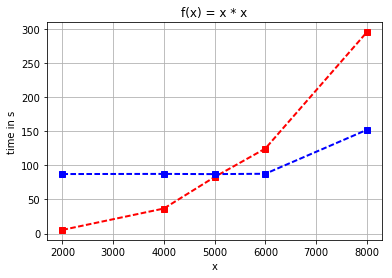

In [139]:
%matplotlib inline
x = [2000, 4000, 5000, 6000, 8000]
y = [5.293, 36.736, 83.031, 124.862, 295.771]
mem = [ 87.4, 87.6 ,87.3 ,87.8,152.3]

fig, ax = plt.subplots()
ax.plot(x, y, color='red', linestyle='--', linewidth=2, marker='s')
ax.plot(x, mem, color='blue', linestyle='--', linewidth=2, marker='s')
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('time in s')
ax.set_title('f(x) = x * x')

### Input Format

In [ ]:
{
  "matA": {
    "bucket": "jmue-matrix-tests",
    "key": "sc4000",
    "split": { ... }
  },
  "matB": {
      "bucket": "jmue-matrix-tests",
      "key": "sc4000t",
      "split": { ... }
  },
  "result": {
      "bucket": "jmue-matrix-tests",
      "key": "sc4000-result"
  }
}

{
  "matA": {
    "bucket": "jmue-matrix-tests",
    "key": "sc4000",
    "split": {
      "x1": 0,
      "y1": 0,
      "x2":1000,
      "y2":1000
    }
  },
  "matB": {
      "bucket": "jmue-matrix-tests",
      "key": "sc4000t",
      "split": {
        "x1": 0,
        "y1": 0,
        "x2":1000,
        "y2":1000
      }
  },
  "result": {
      "bucket": "jmue-matrix-tests",
      "key": "sc4000-result"
  }
}

# A split
{
  "split": {
    "x1": 0,
    "y1": 0,
    "x2":1000,
    "y2":1000
  }
}

In [175]:
matrix = { "bucket": "jmue-matrix-tests", "key": "sc4000", "split": { "x1": 0, "y1": 0, "x2":1000, "y2":1000 } }
x1 = matrix['split']['x1']
y1 = matrix['split']['y1']
key = matrix['key'] +  "/m_" + str(x1) + "_" + str(y1) + ".npy"
print key

sc4000/m_0_0.npy


In [184]:
if not False:
    print "False"

False


In [185]:
if not os.path.exists('/tmp/' + matrix['key']):
    os.mkdir('/tmp/' + matrix['key'])
s3_client.download_file('jmue-matrix-tests', key, '/tmp/' + key)
split = np.load('/tmp/' + key)

In [174]:
split

array([[   0,    1,    2, ...,  997,  998,  999],
       [   1,    2,    3, ...,  998,  999, 1000],
       [   2,    3,    4, ...,  999, 1000, 1001],
       ..., 
       [ 997,  998,  999, ..., 1994, 1995, 1996],
       [ 998,  999, 1000, ..., 1995, 1996, 1997],
       [ 999, 1000, 1001, ..., 1996, 1997, 1998]])

In [5]:
import json
import math

In [83]:
b = 5
a = {"key": b, "key2": "Hello"}
sfn_input = json.dumps({"value": a["key"]})

In [84]:
sfn_input

'{"value": 5}'

In [98]:
int(math.ceil(4030.0/2000.0))

3

In [150]:
ssl = 1000
def call_multi(i,j,k):
    print "x1", str(i*ssl), "y1", str(k*ssl), "| x1", str(k*ssl), "y1", str(j*ssl)
    print "x2", str((i+1)*ssl), "y2", str((k+1)*ssl), "| x2", str((k+1)*ssl), "y2", str((j+1)*ssl)

In [151]:
m = 3
n = 2
p = 2

for i in range(m):
    for j in range(n):
        for k in range(p):
            print "A" + str(i+1) + str(k+1) + "*" + "B" + str(k+1) + str(j+1)
            call_multi(i,j,k)
        print ""

A11*B11
x1 0 y1 0 | x1 0 y1 0
x2 1000 y2 1000 | x2 1000 y2 1000
A12*B21
x1 0 y1 1000 | x1 1000 y1 0
x2 1000 y2 2000 | x2 2000 y2 1000

A11*B12
x1 0 y1 0 | x1 0 y1 1000
x2 1000 y2 1000 | x2 1000 y2 2000
A12*B22
x1 0 y1 1000 | x1 1000 y1 1000
x2 1000 y2 2000 | x2 2000 y2 2000

A21*B11
x1 1000 y1 0 | x1 0 y1 0
x2 2000 y2 1000 | x2 1000 y2 1000
A22*B21
x1 1000 y1 1000 | x1 1000 y1 0
x2 2000 y2 2000 | x2 2000 y2 1000

A21*B12
x1 1000 y1 0 | x1 0 y1 1000
x2 2000 y2 1000 | x2 1000 y2 2000
A22*B22
x1 1000 y1 1000 | x1 1000 y1 1000
x2 2000 y2 2000 | x2 2000 y2 2000

A31*B11
x1 2000 y1 0 | x1 0 y1 0
x2 3000 y2 1000 | x2 1000 y2 1000
A32*B21
x1 2000 y1 1000 | x1 1000 y1 0
x2 3000 y2 2000 | x2 2000 y2 1000

A31*B12
x1 2000 y1 0 | x1 0 y1 1000
x2 3000 y2 1000 | x2 1000 y2 2000
A32*B22
x1 2000 y1 1000 | x1 1000 y1 1000
x2 3000 y2 2000 | x2 2000 y2 2000



In [242]:
def partition(matrix, x, y):
    split = matrix['split']
    x += split['x1']/1000
    y += split['y1']/1000
    partition_factor = ((split['x2']-split['x1'])/2)/1000 # length of split us twice the size of a partition

    filename = "m_" + str(partition_factor*x) + "_" + str(partition_factor*y) + ".npy"
    key = matrix['folder'] + "/" + filename # e.g. m_0_0.npy

    if not os.path.exists('/tmp/' + matrix['folder']):
        os.mkdir('/tmp/' + matrix['folder'])

    print key
    s3_client.download_file(matrix['bucket'], key, '/tmp/' + key)
    return np.load('/tmp/' + key)

In [241]:
s3_client.download_file("jmue-matrix-tests", "sc4000/m_3_2.npy", '/tmp/sc4000/m_3_2.npy')

In [244]:
matrix = { "bucket": "jmue-matrix-tests", "folder": "sc4000", "split": { "x1": 2000, "y1": 2000, "x2":4000, "y2":4000 } }
partition(matrix=matrix, x=1, y=0)

sc4000/m_3_2.npy


array([[5000, 5001, 5002, ..., 5997, 5998, 5999],
       [5001, 5002, 5003, ..., 5998, 5999, 6000],
       [5002, 5003, 5004, ..., 5999, 6000, 6001],
       ..., 
       [5997, 5998, 5999, ..., 6994, 6995, 6996],
       [5998, 5999, 6000, ..., 6995, 6996, 6997],
       [5999, 6000, 6001, ..., 6996, 6997, 6998]])

## Building a State Machine in Code

In [78]:
def task_state(resource, next_state=None):
    task_state = {
            "Type": "Task",
            "Resource": resource,
            "End": True
    }
    if next_state is not None:
        task_state["End"] = False
        task_state["Next"] = next_state
    return task_state

In [79]:
def pass_state(next_state, result=None, resultPath=None, outputPath=None):
    return {
              "Type": "Pass",
              "Result": result,
              "ResultPath": resultPath,
              "OutputPath": outputPath,
              "Next": next_state
    }

In [114]:
def parallel_state(branches, next_state, resultPath=None, outputPath=None):
    parallel_state = {
            "Type": "Parallel",
            "Next": next_state,
            "Branches": branches
    }
    if resultPath is not None:
        parallel_state["ResultPath"] = resultPath
    
    if outputPath is not None:
        parallel_state["OutputPath"] = outputPath
    
    return parallel_state

In [81]:
def branch(startAt, states):
    return {
        "StartAt": startAt,
        "States": states
    }

In [118]:
def create_strassen_sfn(unit=""):
    branches = []
    for index in range(0,7):
        unit_m = "U{}_m{}".format(unit, index) # U0_m_0
        unit_m_lambda = "U{}_m{}_lambda".format(unit, index) # U0_m_0_lambda
        states = {
            unit_m: pass_state(next_state=unit_m_lambda, result=index, resultPath="$.intermediate", outputPath="$"),
            unit_m_lambda: task_state(resource="arn:aws:lambda:eu-central-1:146904559692:function:mmultiply-prod-strassen-split-intermediate")
        }
        branches.append(branch(states=states, startAt=unit_m))

    unit_name = "unit" + unit
    i_name = "U{}_Intermediate".format(unit)
    c_name = "U{}_Collect".format(unit)
    
    unit_setup = pass_state(next_state=i_name, result=unit, resultPath="$.unit", outputPath="$")
    intermediates = parallel_state(branches=branches, next_state=c_name, resultPath="$.responses", outputPath="$")
    collect = task_state(resource="arn:aws:lambda:eu-central-1:146904559692:function:mmultiply-prod-strassen-split-collector")
        
    states = { unit_name: unit_setup, i_name: intermediates, c_name: collect }
    return branch(startAt=unit_name, states=states)

In [122]:
accumulation_arn="arn:aws:lambda:eu-central-1:146904559692:function:mmultiply-prod-unit-accumulator"
unit_branches = []
for i in range(0,2):
    unit_branches.append(create_strassen_sfn(unit=str(i)))

split_states = {
    "Accumulate": task_state(resource=accumulation_arn),
    "Units": parallel_state(branches=unit_branches, next_state="Accumulate", resultPath="$.responses", outputPath="$")
}
partial = branch(startAt="Units", states=split_states)

In [123]:
with open('/Users/Johannes/Uni/Master/Master Arbeit/repos/matrix-operations/state-machines/created.asl', 'w') as file:
    json.dump(partial, file)

In [124]:
result = { "folder": "sc4000-result"}
split = 3
block_index = "00"
response = s3_client.list_objects_v2(
      Bucket="jmue-matrix-tests",
      Prefix="{}/S{}_X{}".format(result['folder'], split, block_index)
    )

In [125]:
response

{u'Contents': [{u'ETag': '"675ba5b88cb01f66bd6b56d15646cc5e"',
   u'Key': 'sc4000-result/S3_X00_U0',
   u'LastModified': datetime.datetime(2017, 8, 4, 15, 59, 30, tzinfo=tzutc()),
   u'Size': 8000080,
   u'StorageClass': 'STANDARD'},
  {u'ETag': '"675ba5b88cb01f66bd6b56d15646cc5e"',
   u'Key': 'sc4000-result/S3_X00_U1',
   u'LastModified': datetime.datetime(2017, 8, 4, 15, 59, 25, tzinfo=tzutc()),
   u'Size': 8000080,
   u'StorageClass': 'STANDARD'}],
 u'IsTruncated': False,
 u'KeyCount': 2,
 u'MaxKeys': 1000,
 u'Name': 'jmue-matrix-tests',
 u'Prefix': 'sc4000-result/S3_X00',
 'ResponseMetadata': {'HTTPHeaders': {'content-type': 'application/xml',
   'date': 'Fri, 04 Aug 2017 16:19:37 GMT',
   'server': 'AmazonS3',
   'transfer-encoding': 'chunked',
   'x-amz-bucket-region': 'eu-central-1',
   'x-amz-id-2': 'e5IR4vIgZJX00HgHbBgBixJWhyqTlnZEKdV+bQatEGkGUysJGlAbJeewKRGgS4YVQvJ5IJth4g0=',
   'x-amz-request-id': '11F1494C37A87A8E'},
  'HTTPStatusCode': 200,
  'HostId': 'e5IR4vIgZJX00HgHbBg

### Padded matrix multiplication has the same result

In [5]:
import numpy as np
j = np.array([[x for x in range(10)],
              [x for x in range(10)],
              [x for x in range(10)],
              [x for x in range(10)],
              [x for x in range(10)]])
j_padded = np.array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
i = j.transpose()
i_padded = j_padded.transpose()
np.array_equal(i_padded.dot(j_padded), i.dot(j))

True